In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [17]:
#upload sbux.csv
from google.colab import files
sbux = files.upload()

Saving SBUX.csv to SBUX.csv


In [18]:
df = pd.read_csv('SBUX.csv')

In [19]:
df.head()

,open,high,low,close,volume,Name
0,27.920,28.325,27.920,28.185,7146296,SBUX
1,28.260,28.260,27.930,28.070,5457354,SBUX
2,28.000,28.275,27.975,28.130,8665592,SBUX
3,28.230,28.230,27.750,27.915,7022056,SBUX
4,27.765,27.905,27.675,27.775,8899188,SBUX


In [20]:
df.tail()

,open,high,low,close,volume,Name
1254,56.280,56.42,55.89,56.00,14690146,SBUX
1255,55.900,56.32,55.70,55.77,15358909,SBUX
1256,55.530,56.26,54.57,54.69,16059955,SBUX
1257,53.685,56.06,53.56,55.61,17415065,SBUX
1258,55.080,55.43,54.44,54.46,13927022,SBUX


In [21]:
series = df['close'].values.reshape(-1, 1)

In [22]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [23]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [24]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
20/20 [==============================] - 7s 38ms/step - loss: 0.1559 - val_loss: 0.1663
Epoch 2/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0364
Epoch 3/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0492
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0064 - val_loss: 0.0373
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0304
Epoch 6/80
20/20 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0369
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0053 - val_loss: 0.0250
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0052 - val_loss: 0.0278
Epoch 9/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0234
Epoch 10/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0513
Epoch 11/80


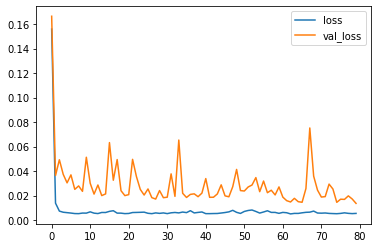

In [25]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


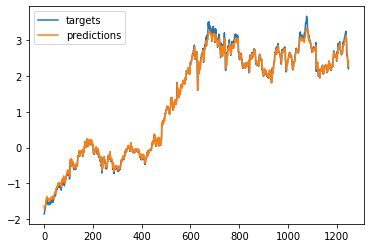

In [26]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

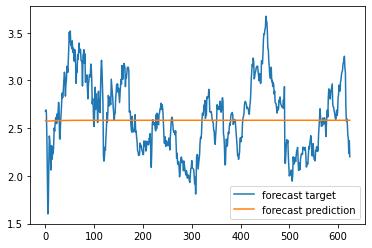

In [27]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


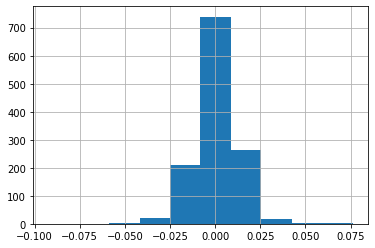

In [ ]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [ ]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [ ]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
20/20 [==============================] - 3s 54ms/step - loss: 0.9915 - val_loss: 1.1306
Epoch 2/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9876 - val_loss: 1.1597
Epoch 3/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9850 - val_loss: 1.1324
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9863 - val_loss: 1.1440
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9829 - val_loss: 1.1412
Epoch 6/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9824 - val_loss: 1.1343
Epoch 7/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9873 - val_loss: 1.1525
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9816 - val_loss: 1.1422
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9835 - val_loss: 1.1486
Epoch 10/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9791 - val_loss: 1.1465
Epoch 11/80

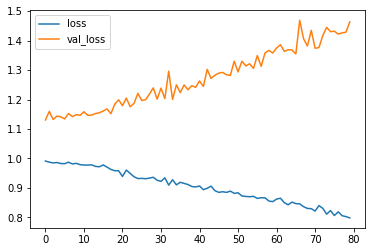

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


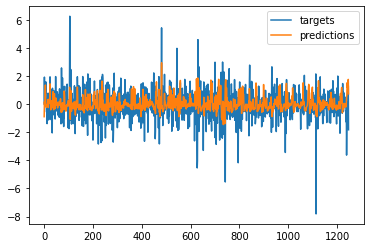

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

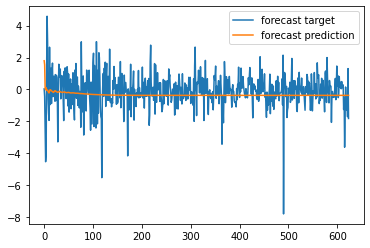

In [ ]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [ ]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [ ]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [ ]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [ ]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 3s 32ms/step - loss: 0.6955 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.5125 - val_loss: 0.6933 - val_accuracy: 0.5024
Epoch 3/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6928 - accuracy: 0.5089 - val_loss: 0.6921 - val_accuracy: 0.5073
Epoch 4/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6944 - accuracy: 0.5173 - val_loss: 0.6970 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6918 - accuracy: 0.5113 - val_loss: 0.6971 - val_accuracy: 0.4902
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.5209 - val_loss: 0.6944 - val_accuracy: 0.4927
Epoch 7/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6895 - accuracy: 0.5614 - val_loss: 0.6918 - val_accuracy: 0.5122
Epoch 8

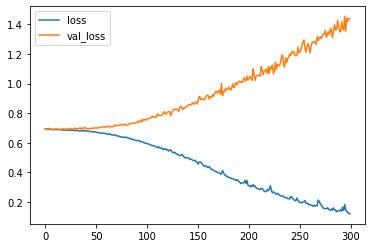

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

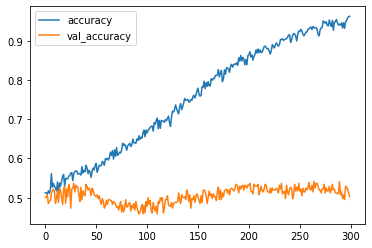

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()